In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import tensorflow as tf 
import numpy as np
import os
import matplotlib.pyplot as plt 

def listdir_nohidden(path):
    for f in os.listdir(path):
        if not f.startswith('.'):
            yield f

rawdir = listdir_nohidden('/content/drive/MyDrive/301 Project/FERG_DB_256_reduced')
Name = sorted(rawdir)
n = len(Name)
N = list(range(n))
string_to_num_mapping = dict(zip(Name,N)) 
num_to_string_mapping = dict(zip(N,Name)) 
string_to_num_mapping

{'anger': 0,
 'disgust': 1,
 'fear': 2,
 'joy': 3,
 'neutral': 4,
 'sadness': 5,
 'surprise': 6}

In [4]:
img_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip=False,
    vertical_flip=False,
    validation_split=0.3,
    rescale=1./256)
root_dir = '/content/drive/MyDrive/301 Project/FERG_DB_256_reduced'

img_generator_flow_train = img_generator.flow_from_directory(
    directory=root_dir,
    target_size=(256,256),
    batch_size=32,
    color_mode='rgb',
    shuffle=False,
    class_mode='categorical',
    subset="training")

img_generator_flow_valid = img_generator.flow_from_directory(
    directory=root_dir,
    target_size=(256,256),
    batch_size=32,
    color_mode='rgb',
    shuffle=False,
    class_mode='categorical',
    subset="validation")


imgs, labels = next(iter(img_generator_flow_train))
for img, label in zip(imgs, labels):
  value=np.argmax(label)
  plt.imshow(img)
  plt.title(num_to_string_mapping[value])
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [5]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt


In [6]:
class Inception(tf.keras.Model):
    # `c1`--`c4` are the number of output channels for each branch
    def __init__(self, c1, c2, c3, c4):
        super().__init__()
        self.b1_1 = tf.keras.layers.Conv2D(c1, 1, activation='relu')
        self.b2_1 = tf.keras.layers.Conv2D(c2[0], 1, activation='relu')
        self.b2_2 = tf.keras.layers.Conv2D(c2[1], 3, padding='same',
                                           activation='relu')
        self.b3_1 = tf.keras.layers.Conv2D(c3[0], 1, activation='relu')
        self.b3_2 = tf.keras.layers.Conv2D(c3[1], 5, padding='same',
                                           activation='relu')
        self.b4_1 = tf.keras.layers.MaxPool2D(3, 1, padding='same')
        self.b4_2 = tf.keras.layers.Conv2D(c4, 1, activation='relu')

    def call(self, x):
        b1 = self.b1_1(x)
        b2 = self.b2_2(self.b2_1(x))
        b3 = self.b3_2(self.b3_1(x))
        b4 = self.b4_2(self.b4_1(x))
        return tf.keras.layers.Concatenate()([b1, b2, b3, b4])

## GoogleNet

In [14]:
model = tf.keras.models.Sequential()
#b1
#model.add(layers.Conv2D(64, 7, activation='relu',input_shape=(224, 224, 3)))
model.add(layers.Conv2D(64, 7, strides=2, padding='same', activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPool2D(pool_size=3, strides=2,padding='same'))

#b2
model.add(layers.Conv2D(64, 3, strides=1, padding='same', activation='relu'))
model.add(layers.Conv2D(192, 3, strides=1, padding='same', activation='relu'))
model.add(layers.MaxPool2D(pool_size=3, strides=2, padding='same'))

#b3
model.add(Inception(64, (96, 128), (16, 32), 32))
model.add(Inception(128, (128, 192), (32, 96), 64))
model.add(layers.MaxPool2D(pool_size=3, strides=2, padding='same'))

#b4
model.add(Inception(192, (96, 208), (16, 48), 64))
model.add(Inception(160, (112, 224), (24, 64), 64))
model.add(Inception(128, (128, 256), (24, 64), 64))
model.add(Inception(112, (144, 288), (32, 64), 64))
model.add(Inception(256, (160, 320), (32, 128), 128))
model.add(layers.MaxPool2D(pool_size=3, strides=2, padding='same'))

#b5
model.add(Inception(256, (160, 320), (32, 128), 128))
model.add(Inception(384, (192, 384), (48, 128), 128))
model.add(layers.GlobalAvgPool2D())
model.add(layers.Dropout(0.4))
model.add(layers.Flatten())

#model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(7, activation='softmax'))



In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 64)      9472      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 56, 56, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 56, 64)        36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 192)       110784    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 28, 192)      0         
 2D)                                                             
                                                                 
 inception (Inception)       (None, 28, 28, 256)       1

In [9]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = [tf.keras.metrics.CategoricalAccuracy()])

In [10]:
history = model.fit(img_generator_flow_train, 
          validation_data=img_generator_flow_valid, epochs=70) 


Epoch 1/70
 992/1227 [=======================>......] - ETA: 1:39:31 - loss: 1.9463 - categorical_accuracy: 0.1366

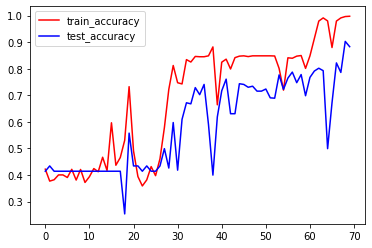

In [11]:
plt.plot(model.history.history["categorical_accuracy"], c="r", label="train_accuracy")
plt.plot(model.history.history["val_categorical_accuracy"], c="b", label="test_accuracy")
plt.legend(loc="upper left")
plt.show()

In [15]:
sum(history.history["val_categorical_accuracy"])/len(history.history["val_categorical_accuracy"])

0.5880288468939917

In [16]:
max(history.history["val_categorical_accuracy"])

0.9030544757843018

# GoogleNet - 
adding one more 64 dense layer and BatchNormalization

In [17]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, LeakyReLU, Dense, Dropout

In [18]:
model2 = tf.keras.models.Sequential()

#b1
#model.add(layers.Conv2D(64, 7, activation='relu',input_shape=(224, 224, 3)))
model2.add(layers.Conv2D(64, 7, strides=2, padding='same', activation='relu', input_shape=(224, 224, 3)))
#model2.add(layers.LeakyReLU())
model2.add(BatchNormalization())
model2.add(layers.MaxPool2D(pool_size=3, strides=2,padding='same'))

#b2
model2.add(layers.Conv2D(64, 3, strides=1, padding='same', activation='relu'))
model2.add(layers.Conv2D(192, 3, strides=1, padding='same', activation='relu'))
#model2.add(layers.LeakyReLU())
model2.add(BatchNormalization())
model2.add(layers.MaxPool2D(pool_size=3, strides=2, padding='same'))

#b3
model2.add(Inception(64, (96, 128), (16, 32), 32))
model2.add(Inception(128, (128, 192), (32, 96), 64))
#model2.add(layers.LeakyReLU())
model2.add(layers.MaxPool2D(pool_size=3, strides=2, padding='same'))

#b4
model2.add(Inception(192, (96, 208), (16, 48), 64))
model2.add(Inception(160, (112, 224), (24, 64), 64))
model2.add(Inception(128, (128, 256), (24, 64), 64))
model2.add(Inception(112, (144, 288), (32, 64), 64))
model2.add(Inception(256, (160, 320), (32, 128), 128))
#model2.add(layers.LeakyReLU())
model2.add(layers.MaxPool2D(pool_size=3, strides=2, padding='same'))


#b5
model2.add(Inception(256, (160, 320), (32, 128), 128))
model2.add(Inception(384, (192, 384), (48, 128), 128))
#model2.add(layers.LeakyReLU())
model2.add(layers.GlobalAvgPool2D())
model2.add(layers.Flatten())

#model.add(layers.Dense(64, activation='relu'))
model2.add(layers.Dense(64, activation='relu'))
model2.add(layers.Dense(64, activation='relu'))
model2.add(layers.Dense(7, activation='softmax'))


In [19]:
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = [tf.keras.metrics.CategoricalAccuracy()])

In [20]:
img_generator_flow_train.reset()
history = model2.fit(img_generator_flow_train, 
          validation_data=img_generator_flow_valid, epochs=100) 


Epoch 1/100
55/55 [==============================] - 15s 207ms/step - loss: 6.0527 - categorical_accuracy: 0.3783 - val_loss: 1.1440 - val_categorical_accuracy: 0.4143
Epoch 2/100
55/55 [==============================] - 11s 192ms/step - loss: 1.1140 - categorical_accuracy: 0.4369 - val_loss: 1.2860 - val_categorical_accuracy: 0.4143
Epoch 3/100
55/55 [==============================] - 11s 195ms/step - loss: 1.1500 - categorical_accuracy: 0.3623 - val_loss: 1.4009 - val_categorical_accuracy: 0.4143
Epoch 4/100
55/55 [==============================] - 11s 193ms/step - loss: 1.1653 - categorical_accuracy: 0.3652 - val_loss: 1.1082 - val_categorical_accuracy: 0.4143
Epoch 5/100
55/55 [==============================] - 11s 192ms/step - loss: 1.2060 - categorical_accuracy: 0.3680 - val_loss: 1.1050 - val_categorical_accuracy: 0.4343
Epoch 6/100
55/55 [==============================] - 11s 193ms/step - loss: 1.0714 - categorical_accuracy: 0.2884 - val_loss: 1.0183 - val_categorical_accuracy:

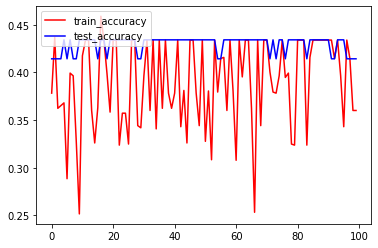

In [21]:
plt.plot(model2.history.history["categorical_accuracy"], c="r", label="train_accuracy")
plt.plot(model2.history.history["val_categorical_accuracy"], c="b", label="test_accuracy")
plt.legend(loc="upper left")
plt.show()

In [22]:
max(history.history["categorical_accuracy"])

0.45904436707496643